In [1]:
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import numpy as np
import boto3, os, sys
import pickle

#----------------------------------------------------------------------------------------------------

import seaborn as sns



load_dotenv(find_dotenv())

#https://github.com/fmfn/BayesianOptimization

True

In [2]:
dt = pd.read_csv("idfinance_new.csv")
dt.columns

Index(['id', 'sex', 'age', 'city', 'employment', 'Salary', 'Scoring ',
       'Segment ', 'Default_ind', 'Country of Residence ', 'Education'],
      dtype='object')

In [3]:
#### P R E P R O C E S S I N G (QUASH)

#id,sex,age,city,employment,Salary,Scoring ,Segment ,Default_ind,Country of Residence ,Education



dt.columns = ['id', 'sex', 'age','city','employment','salary','scoring','segment','default_ind','country of residence ','education']
dt['good_creditor'] = 1 - dt['default_ind']
dt = dt.drop(['default_ind'],axis=1)
dt = dt[dt['good_creditor'] != 2]

dt_A = dt[dt['segment'] == 'A']
dt_B = dt[dt['segment'] == 'B']



dt_preprocessed = pd.DataFrame(dt,columns=dt.columns) # creo un nuevo dataframe
dt_preprocessed_A = dt_preprocessed[dt_preprocessed['segment']=='A']
dt_preprocessed_B = dt_preprocessed[dt_preprocessed['segment']=='B']
dt_preprocessed_A = dt_preprocessed_A.drop(['segment','id'],axis=1)
dt_preprocessed_B = dt_preprocessed_B.drop(['segment','id'],axis=1)
dt_preprocessed_A.columns




Index(['sex', 'age', 'city', 'employment', 'salary', 'scoring',
       'country of residence ', 'education', 'good_creditor'],
      dtype='object')

In [4]:
##Segment A model scoring

segment_a_treshold = 93
y_true = dt_A['good_creditor']
y_pred = [1 if y >= segment_a_treshold else 0 for y in dt_A['scoring']]
prec = sum(np.multiply(y_true,y_pred)) / (sum( np.multiply([ 1 - pr for pr in y_true], y_pred)) + sum(np.multiply(y_true,y_pred)))
recall = sum(np.multiply(y_true,y_pred)) / (sum( np.multiply([ 1 - pr for pr in y_pred], y_true)) + sum(np.multiply(y_true,y_pred)))
f_1 = 2 * prec * recall/ (prec + recall)
prec, recall, f_1

(0.6506024096385542, 0.6835443037974683, 0.6666666666666666)

In [5]:
##Segment B model scoring
segment_b_treshold = 515
y_true = dt_B['good_creditor']
y_pred = [1 if y >= segment_b_treshold else 0 for y in dt_B['scoring']]
prec = sum(np.multiply(y_true,y_pred)) / (sum( np.multiply([ 1 - pr for pr in y_true], y_pred)) + sum(np.multiply(y_true,y_pred)))
recall = sum(np.multiply(y_true,y_pred)) / (sum( np.multiply([ 1 - pr for pr in y_pred], y_true)) + sum(np.multiply(y_true,y_pred)))
f_1 = 2 * prec * recall/ (prec + recall)
prec, recall, f_1

(0.782733224222586, 0.8601618705035972, 0.8196229648671809)

In [6]:
dt_pre_all = dt_preprocessed_A.append([dt_preprocessed_B])
#dt_preprocessed_all = dt_preprocessed_all.drop(['scoring'], axis=1)
pre_feature_headers = dt_pre_all.drop(['good_creditor'], axis=1).columns.to_list()
dt_pre_all.head()


,sex,age,city,employment,salary,scoring,country of residence,education,good_creditor
28,Male,54,Toluca,FULL_TIME,13500,112,Mexico,UNIVERSITY,1
88,Female,45,Ciudad de México,AUTONOMIC,6000,115,Mexico,BACCALAUREATE,1
97,Male,45,Puebla (Heroica Puebla),AUTONOMIC,12000,80,Mexico,UNIVERSITY,0
127,Male,43,Ciudad General Escobedo,FULL_TIME,40000,99,Mexico,UNIVERSITY,1
135,Female,41,Coatzacoalcos,FULL_TIME,20000,91,Mexico,UNIVERSITY,1


In [7]:
pre_feature_headers


['sex',
 'age',
 'city',
 'employment',
 'salary',
 'scoring',
 'country of residence ',
 'education']

In [8]:
#### P R E P R O C E S S I N G ( Y E I F E R)

In [9]:
# VARIABLES CATEGÓRICAS

# Trataremos las variables categóricas: sex, city, education y, employment, utilizando la técnica de: Mean Encoding, de la 
# siguiente manera: ( likelihood=Goods/(Goods+Bads) = mean (target) ) 

# La variable categórica: country of residence, se descartó por tener nada más un solo valor.

#----------------------------------------------------------------------------------------------------
# Variable:sex
# Calculo del mapping: {variable: target_mean}
item_id_target_mean =dt_pre_all.groupby('sex').good_creditor.mean()

dt_pre_all['sex_target_enc'] = dt_pre_all['sex'].map(item_id_target_mean)

# Correlación entre la variable y la variable objetivo.
encoded_feature =dt_pre_all['sex_target_enc'].values
print('Variable: sex')
print(np.corrcoef(dt_pre_all['good_creditor'].values, encoded_feature)[0][1])

#----------------------------------------------------------------------------------------------------
# Variable:city
item_id_target_mean =dt_pre_all.groupby('city').good_creditor.mean()
dt_pre_all['city_target_enc'] = dt_pre_all['city'].map(item_id_target_mean)
encoded_feature = dt_pre_all['city_target_enc'].values
print('Variable: city')
print(np.corrcoef(dt_pre_all['good_creditor'].values, encoded_feature)[0][1])

#----------------------------------------------------------------------------------------------------
# Variable:education
item_id_target_mean =dt_pre_all.groupby('education').good_creditor.mean()
dt_pre_all['education_target_enc'] = dt_pre_all['education'].map(item_id_target_mean)
encoded_feature = dt_pre_all['education_target_enc'].values
print('Variable: education')
print(np.corrcoef(dt_pre_all['good_creditor'].values, encoded_feature)[0][1])

#----------------------------------------------------------------------------------------------------
# Variable:employment
item_id_target_mean =dt_pre_all.groupby('employment').good_creditor.mean()
dt_pre_all['employment_target_enc'] = dt_pre_all['employment'].map(item_id_target_mean)
encoded_feature = dt_pre_all['employment_target_enc'].values
print('Variable: employment')
print(np.corrcoef(dt_pre_all['good_creditor'].values, encoded_feature)[0][1])


Variable: sex
0.030198275254523375
Variable: city
0.39124870702214437
Variable: education
0.07852227674857366
Variable: employment
0.12149971271729404


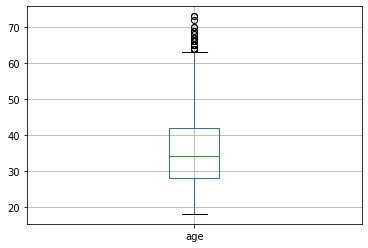

In [10]:
# VARIABLES NUMERICAS

dt_pre_all.boxplot(column='age')
#dt_pre_all.boxplot(column='salary')
#dt_pre_all.boxplot(column='scoring')


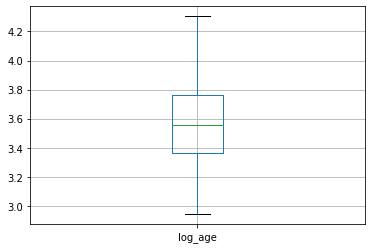

In [11]:
# El tratamiento a las variables númericas está destinado a normalizar su distribución, por lo cual, hemos seleccionado
# la ecuación: Log Transform ( np.log (1 + x ) )

dt_pre_all['log_age']=np.log(1 + dt_pre_all['age'] )
dt_pre_all['log_salary']=np.log(1 + dt_pre_all['salary'] )  
dt_pre_all['log_scoring']=np.log(1 + dt_pre_all['scoring'] )

dt_pre_all.boxplot(column='log_age')

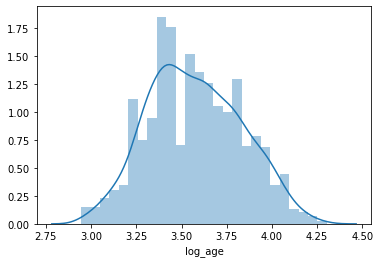

In [12]:
# Las distribuciones de las variables numericas estan más cercanas a su media.
sns.distplot(dt_pre_all['log_age'])

#sns.distplot(dt_pre_all['log_salary'])
#sns.distplot(dt_pre_all['log_scoring'])

In [13]:
dt_pre_all.head()

,sex,age,city,employment,salary,scoring,country of residence,education,good_creditor,sex_target_enc,city_target_enc,education_target_enc,employment_target_enc,log_age,log_salary,log_scoring
28,Male,54,Toluca,FULL_TIME,13500,112,Mexico,UNIVERSITY,1,0.724231,0.857143,0.769874,0.761944,4.007333,9.510519,4.727388
88,Female,45,Ciudad de México,AUTONOMIC,6000,115,Mexico,BACCALAUREATE,1,0.751007,0.763602,0.707715,0.634807,3.828641,8.699681,4.753590
97,Male,45,Puebla (Heroica Puebla),AUTONOMIC,12000,80,Mexico,UNIVERSITY,0,0.724231,0.685185,0.769874,0.634807,3.828641,9.392745,4.394449
127,Male,43,Ciudad General Escobedo,FULL_TIME,40000,99,Mexico,UNIVERSITY,1,0.724231,0.727273,0.769874,0.761944,3.784190,10.596660,4.605170
135,Female,41,Coatzacoalcos,FULL_TIME,20000,91,Mexico,UNIVERSITY,1,0.751007,0.815789,0.769874,0.761944,3.737670,9.903538,4.521789


In [14]:
# Existe una ligera correlacion entre 

## Dataframe para split
train_valid_sample=dt_pre_all.drop(columns=['sex', 'age', 'city', 'employment', 'salary', 'scoring','country of residence ', 'education',])

## Renombre de variables: "sex_target_enc": "sex", etc.
train_valid_sample=train_valid_sample.rename(columns={"sex_target_enc": "sex", "city_target_enc": "city","education_target_enc": "education","employment_target_enc": "employment", "log_age":"age", "log_salary":"salary", "log_scoring":"scoring"})



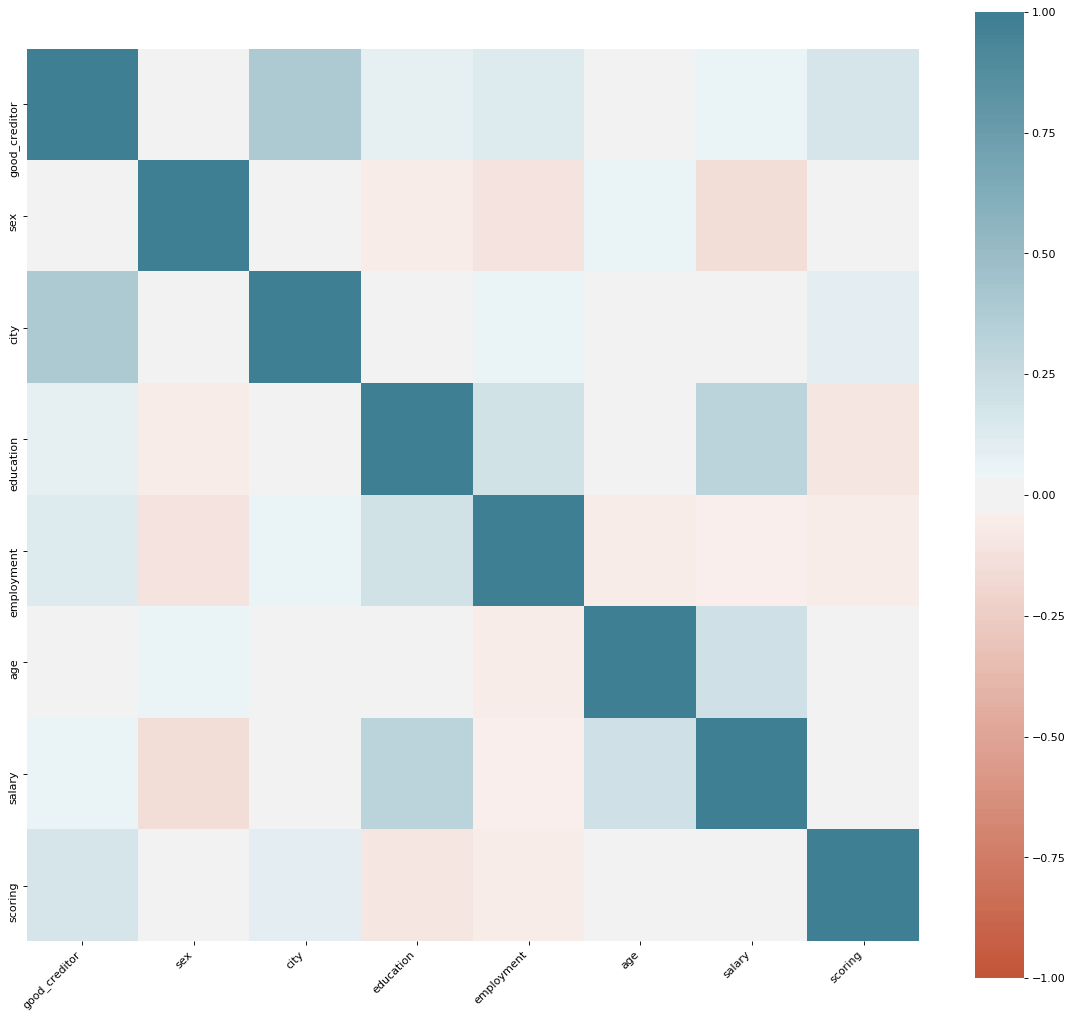

In [15]:
train_valid_sample.head()

import matplotlib.pyplot as plt
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

# Matriz de Correlaciones: Existe una ligera correlación en las variables dependientes, sin embargo, está es débil, no repercute
# gran medida en el performance del modelo y, la variable que más correlacionada con la variable objetivo es: city.

import seaborn as sns
corr = train_valid_sample.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [16]:
# SPLIT TRAIN/VALID

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = train_valid_sample.drop(['good_creditor'],axis=1)
Y = train_valid_sample['good_creditor']
seed = 42
test_size = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [17]:
import numpy as np
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')



pbounds = {
    'learning_rate': (0.001,0.1),
    'n_estimators': (100,1000),
    'max_depth': (3,7), # Parametro cambiado por tener menor numeros de variables.
    'subsample': (1.0, 1.0),  # Change for big datasets
   
    'gamma': (0.01, 3)}

                  
                  
                  
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        gamma):
    
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        subsample=subsample,
       
        objective='binary:logistic',
        )
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc'))

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(init_points=2,n_iter=3)

params = optimizer.max['params']
params['max_depth'] = np.int(params['max_depth'])
params['n_estimators'] = np.int(params['n_estimators'])

model = XGBClassifier(**params)
model.fit(X_train, y_train)

#y_pred = model.predict_proba(X_test)
#y_score = [y[1] for y in y_pred]

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.7514   |  1.257    |  0.07231  |  3.0      |  372.1    |  1.0      |
|  2        |  0.7386   |  0.2861   |  0.01944  |  4.382    |  457.1    |  1.0      |
|  3        |  0.7422   |  2.781    |  0.05016  |  6.595    |  100.1    |  1.0      |
|  4        |  0.7513   |  1.059    |  0.02075  |  3.599    |  999.7    |  1.0      |
|  5        |  0.7042   |  0.2287   |  0.06828  |  6.855    |  249.9    |  1.0      |


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.2568957940606964,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.07231212485077365, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=372, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
params

{'gamma': 1.2568957940606964,
 'learning_rate': 0.07231212485077365,
 'max_depth': 3,
 'n_estimators': 372,
 'subsample': 1.0}

In [19]:
y_pred = model.predict_proba(X_test)
y_score = [y[1] for y in y_pred]

model_performance = pd.DataFrame({"accuracy":[],"precision":[],"recall":[],"f1":[],"cut":[]})
for x in range(0,100):
    pred = [1 if y > (x*0.01) else 0 for y in y_score]
    acc = (y_test == pred).mean()
    prec = sum(np.multiply(y_test,pred)) / (sum( np.multiply([ 1 - pr for pr in y_test], pred)) + sum(np.multiply(y_test,pred)))
    reca = sum(np.multiply(y_test,pred)) / (sum( np.multiply([ 1 - pr for pr in pred], y_test)) + sum(np.multiply(y_test,pred)))
    f_1 = 0.25 * prec * reca/ ((0.25*prec) + reca)
    model_performance = model_performance.append({
        "accuracy": acc,
        "precision": prec,
        "recall": reca,
        "f1": f_1,
        "cut": x * 0.01
    }, ignore_index=True)
#model_performance

In [20]:
threshold = model_performance.iloc[model_performance['f1'].idxmax()]['cut']
# Other interesting views of performance: 
#model_performance[model_performance['cut'].isin(range(35,65))]

GINI = 0.5056735198292326, KS = 24


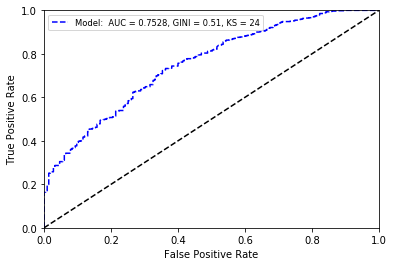

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats
import matplotlib.pyplot as plt
# %matplotlib inline

def plot_roc_curve(y, y_pred, gini, ks):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure()
    plt.plot(fpr, tpr, 'b--', label='%s AUC = %0.4f, GINI = %0.2f, KS = %s' % ('Model: ', roc_auc, gini, ks))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.show()
    
gini = 2 * roc_auc_score(y_test, y_score) - 1
ks = 24#stats.ks_2samp(y_pred[y_pred['y'] == 0]['y_pred'], y_pred[y_pred['y'] == 1]['y_pred']).statistic
print('GINI = %s, KS = %s' % (gini, ks))
plot_roc_curve(y_test, y_score, gini, ks)